# Nested sampling with high-dimensional swyft posterior estimates

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn

import swyft
from swyft.utils.ns import SwyftSimpleSliceSampler
from swyft.lightning.estimators import LogRatioEstimator_Autoregressive

#import pytorch_lightning as pl

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

In [3]:
Nt = 10000
ME = 20
Ns1 = 100
Ns2 = 3000
D = 10

In [4]:
class Sim(swyft.Simulator):
    def __init__(self, sampler = None, D = D):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.sampler = sampler
        self.D = D
    
    def build(self, graph):
        if self.sampler is None:
            z = graph.node("z", lambda: np.random.rand(self.D))
        else:
            z = graph.node("z", lambda: self.sampler())
        x = graph.node("x", lambda z: z-0.5 + np.random.randn(self.D)*0.05, z)

In [5]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3):
        super().__init__()

        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.num_params = D
        self.lre = LogRatioEstimator_Autoregressive(D*2, self.num_params, "z", 0.1, 2, 64)
        
        self.embedding2 = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(D*2)
        )
        
    def forward(self, A, B):
        x = A["x"]
        f = self.embedding2(x)
        result = self.lre(f, A['z'], B['z'])
        return result

In [6]:
sim = Sim()
samples = sim.sample(Nt)
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 128)
net = Network()
trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = ME)
trainer.fit(net, dm)

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/weniger/.conda/envs/lensing/lib/python3.9/site ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /gpfs/home2

Sanity Checking: 0it [00:00, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [7]:
def logl1(net, z):
    B = dict(z = z.to(net.device))
    A = dict(x = torch.zeros(1, D).to(net.device), z = B['z'])
    with torch.no_grad():
        predictions = net(A, B)
    logl = predictions['lrs_total'].logratios.squeeze(-1)
    return logl#.cpu()

In [8]:
net.cuda().eval()
X_init = torch.tensor(samples[:Ns1]["z"]).cuda()
ssss = SwyftSimpleSliceSampler(X_init)
ssss.nested_sampling(lambda z: logl1(net, z), epsilon = 1e-3, logl_th_max = 50);
logl_th = ssss.get_threshold(1e-3)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [9]:
net.cuda().eval()
X_init2, _ = ssss.get_constrained_prior_samples(Ns2, min_logl = logl_th)
ssss2 = SwyftSimpleSliceSampler(X_init2.cuda())
ssss2.nested_sampling(lambda z: logl1(net, z), epsilon = 1e-3, logl_th_max = 50);

  0%|          | 0/100000 [00:00<?, ?it/s]

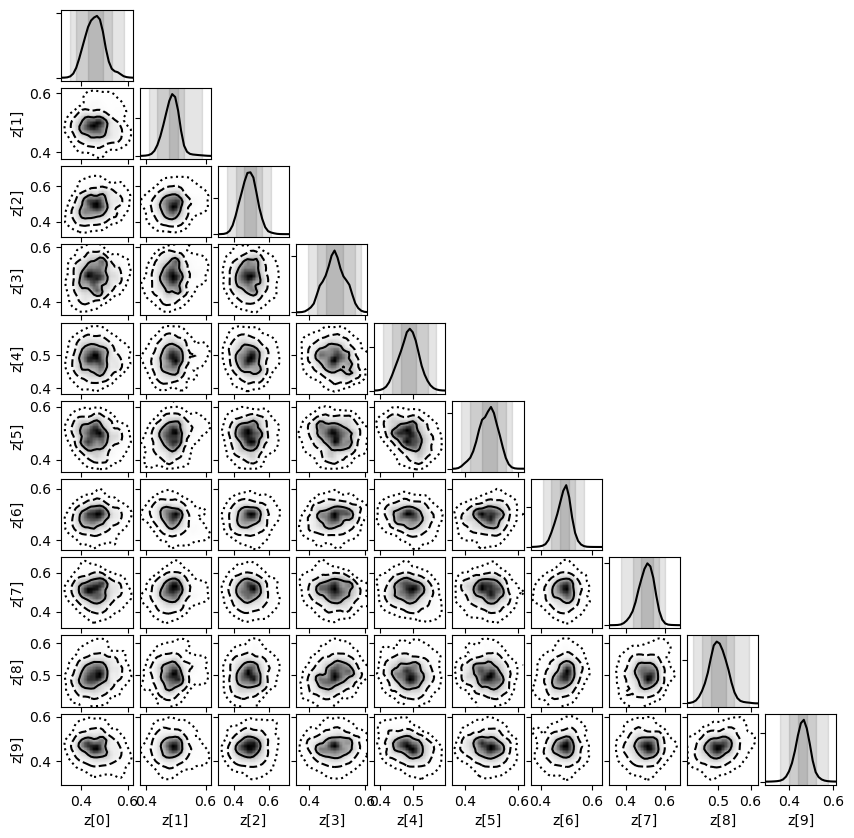

In [10]:
X_post, L_post = ssss2.get_constrained_prior_samples(None, min_logl = logl_th)
lrs = swyft.LogRatioSamples(L_post.unsqueeze(-1), X_post.unsqueeze(-2), np.array([['z[%i]'%i for i in range(10)]]))
swyft.corner(lrs, ['z[%i]'%i for i in range(10)], smooth = 1, bins = 25);

/gpfs/home2/weniger/swyft/swyft/utils/ns.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wt = torch.tensor(wt)
/gpfs/home2/weniger/swyft/swyft/utils/ns.py:162: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wt = torch.tensor(wt)


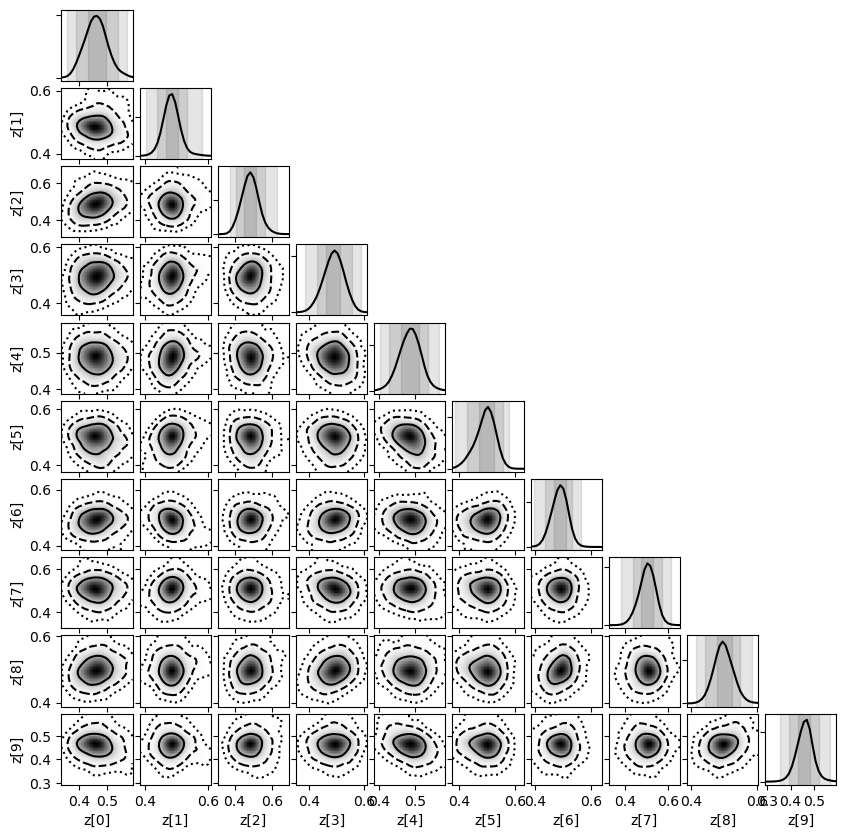

In [11]:
X_post, L_post = ssss2.get_posterior_samples()
lrs = swyft.LogRatioSamples(L_post.unsqueeze(-1)*0, X_post.unsqueeze(-2), np.array([['z[%i]'%i for i in range(10)]]))
swyft.corner(lrs, ['z[%i]'%i for i in range(10)], smooth = 1, bins = 25);